In [2]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy import stats

In [3]:
data= pd.read_csv("marketing_data.csv")

**Examine variables such as Dt_Customer and Income to verify their accurate importation**

In [4]:
data['Income_New']=data[' Income '].str.replace(',', '',regex=False)
data['Income_New']=data['Income_New'].str.replace('$', '',regex=False)
data['Income_New']=data['Income_New'].astype(float)
data['Dt_Customer_New'] = pd.to_datetime(data['Dt_Customer'])

**2. Data Clean up using education and marital status tend to have comparable yearly incomes**

In [5]:
data['Income_New']=data['Income_New'].fillna(data.groupby(['Education', 'Marital_Status'])['Income_New'].transform('mean'))

**3.Create variables to represent the total number of children, age, and total spending.**

In [6]:
data['Age']=datetime.now().year-data['Year_Birth']
data['total_children']=data['Kidhome']+data['Teenhome']
data['total_spending']=data['MntWines'] + data['MntFruits']+ data['MntMeatProducts'] + data['MntFishProducts']+data['MntSweetProducts']+ data['MntGoldProds'] 

**4 Checked outlier treatment as needed.**

In [7]:
q3=data['NumWebVisitsMonth'].quantile(.75)
q1=data['NumWebVisitsMonth'].quantile(.25)
iqr=q3-q1
UB= q3+(1.5*iqr)
data['NumWebVisitsMonth_New']=np.where(data['NumWebVisitsMonth']>UB,UB,data['NumWebVisitsMonth'])

q3=data['NumStorePurchases'].quantile(.75)
q1=data['NumStorePurchases'].quantile(.25)
iqr=q3-q1
UB= q3+(1.5*iqr)
data['NumStorePurchases_New']=np.where(data['NumStorePurchases']>UB,UB,data['NumStorePurchases'])

q3=data['NumWebVisitsMonth'].quantile(.75)
q1=data['NumWebVisitsMonth'].quantile(.25)
iqr=q3-q1
UB= q3+(1.5*iqr)
data['NumWebVisitsMonth_New']=np.where(data['NumWebVisitsMonth']>UB,UB,data['NumWebVisitsMonth'])



**5. ordinal and one-hot encoding based on the various types of categorical
variables**

In [8]:
ode=OrdinalEncoder()
data['Education_New']=ode.fit_transform(data[['Education']])
data['Marital_Status_New']=ode.fit_transform(data[['Marital_Status']])
data['Country_New']=ode.fit_transform(data[['Country']])

**6.  heatmap to illustrate the correlation between different pairs of
variables**

<AxesSubplot: xlabel='Marital_Status_New', ylabel='Age'>

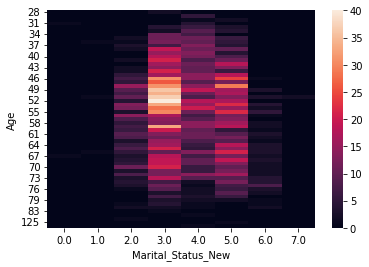

In [9]:
contingency_table = pd.crosstab(data['Age'], data['Marital_Status_New'])
sns.heatmap(contingency_table)


**7.A Older individuals may not possess the same level of technological
proficiency and may, therefore, lean toward traditional in-store shopping
preferences**

In [10]:
data['Age_Group'] = np.where(data['Age'] < 50, 'Younger', 'Older')
data['Tech_Proficiency']=np.where(data['NumWebVisitsMonth']>0,1,0)
younger_proficiency = data[data['Age_Group'] == 'Younger']['Tech_Proficiency']
older_proficiency = data[data['Age_Group'] == 'Older']['Tech_Proficiency']

t_statistic, p_value = stats.ttest_ind(younger_proficiency, older_proficiency)
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in technological proficiency between age groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in technological proficiency between age groups.")

Fail to reject the null hypothesis: There is no significant difference in technological proficiency between age groups.


**7.b Customers with children likely experience time constraints, making online
shopping a more convenient option.**

In [11]:
data['Age_Group'] = np.where(data['Age'] < 50, 'Younger', 'Older')
data['Has_Children'] = np.where(data['total_children'] > 0, 'Yes', 'No')
child_with_web_proficiency = data[data['Has_Children'] == 'Yes']['NumWebPurchases']
child_with_store_proficiency = data[data['Has_Children'] == 'Yes']['NumStorePurchases']

t_statistic, p_value = stats.ttest_ind(child_with_web_proficiency, child_with_store_proficiency)
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in children with Online purchase and children with Store purchase.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in children with Online purchase and children with Store purchase.")

Reject the null hypothesis: There is a significant difference in children with Online purchase and children with Store purchase.


**7.C Sales at physical stores may face the risk of cannibalization by alternative
distribution channels**

In [12]:
NumCatalogPurchases=data['NumCatalogPurchases'].mean()
NumStorePurchases=data['NumStorePurchases'].mean()
NumWebPurchases=data['NumWebPurchases'].mean()
largest = max(NumStorePurchases, NumCatalogPurchases, NumWebPurchases)
if NumStorePurchases == largest:
    print("Store Purchases is High")
elif NumCatalogPurchases == largest:
     print("Catalog Purchases is High")
else:
    print("Web Purchases is High")

Store Purchases is High


**7.D the United States significantly outperform the rest of the world in total purchase volumes**

In [13]:
data['Total_Purchase']=data['NumDealsPurchases']+ data['NumWebPurchases']+data['NumCatalogPurchases']+data['NumStorePurchases']
data['Country_Group'] = data['Country'].apply(lambda x: 'US' if x == 'US' else 'Other')
grouped_data = data.groupby('Country_Group')['Total_Purchase'].sum()
us_total = grouped_data.get('US', 0)
other_total = grouped_data.get('Other', 0)
if us_total > other_total:
    print("Total purchases in the US are higher.")
elif us_total < other_total:
    print("Total purchases in Other countries are higher.")
else:
    print("Total purchases are equal between the US and Other countries.")

Total purchases in Other countries are higher.


**8.A Identify the top-performing products and those with the lowest revenue**
Top performance Products and Lowest revenue

In [20]:
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
total_revenue = data[product_columns].sum()
print('Top Perform Product: ',total_revenue.idxmax())

In [19]:
print('Lowest revenue Product: ',total_revenue.idxmin())

Top Perform Product:  MntWines


**8.B  there is a correlation between customers' age and the
acceptance rate of the last campaign**

In [15]:
print('Correlation between Age and Complaints: ',data['Age'].corr(data['Response']))

Correlation between Age and Complaints:  -0.02132521444197821


**8.C  the country with the highest number of customers who
accepted the last campaign**

In [16]:
accepted_counts = data[data['Response'] == 1].groupby('Country').size()
accepted_counts.idxmax()

'SP'

**8.D there is a discernible pattern in the number of children at
home and the total expenditure**

Correlation between Total Children and Total Spending:  -0.4988876486808991


/tmp/ipykernel_247/29155399.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_spending_children=data.corr()


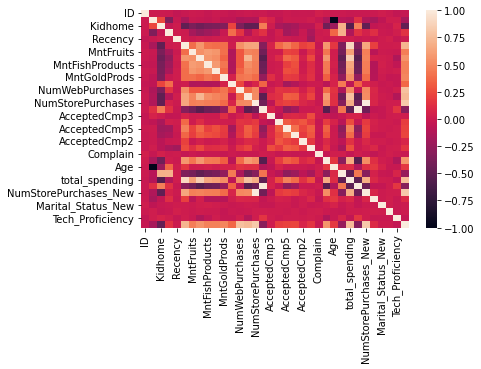

In [17]:
print('Correlation between Total Children and Total Spending: ',data['total_children'].corr(data['total_spending']))
corr_spending_children=data.corr()
sns.heatmap(corr_spending_children);

**8.E Analyze the educational background of customers who lodged complaints
in the last two years**

In [18]:
accepted_counts = data[data['Complain'] == 1].groupby('Education').size()
accepted_counts.idxmax()

'Graduation'